In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.1


In [4]:
import os

In [5]:
dataset_path = os.getcwd() + os.sep + 'te' + os.sep + 'lexicons'
train_path = dataset_path + os.sep + 'te.translit.sampled.train.tsv'
valid_path = dataset_path + os.sep + 'te.translit.sampled.dev.tsv'
test_path = dataset_path + os.sep + 'te.translit.sampled.test.tsv'

In [6]:
train_inputs = []
train_outputs = []
valid_inputs = []
valid_outputs = []
test_inputs = []
test_outputs = []
input_chars = set()
output_chars = set()

In [7]:
include_all = True

In [8]:
with open(train_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
for line in lines[: (len(lines) - 1 )]:
    out,inp,a = line.split('\t')
#     if not include_all and a!=1:
#         continue
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
#     print(out,out[-1],inp,inp[-1])
    out = "\t" + out + "\n"
    train_inputs.append(inp)
    train_outputs.append(out)
    for char in inp:
        if char not in input_chars:
            input_chars.add(char)
    for char in out:
        if char not in output_chars:
            output_chars.add(char)

In [9]:
len(train_inputs)

58550

In [10]:
with open(valid_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
for line in lines[: (len(lines) - 1 )]:
    out,inp,a = line.split('\t')
    if not include_all and a!=1:
        continue
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
#     print(out,out[-1],inp,inp[-1])
    out = "\t" + out + "\n"
    valid_inputs.append(inp)
    valid_outputs.append(out)
#     for char in inp:
#         if char not in input_chars:
#             input_chars.add(char)
#     for char in out:
#         if char not in output_chars:
#             output_chars.add(char)

In [11]:
with open(test_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
for line in lines[: (len(lines) - 1 )]:
    out,inp,a = line.split('\t')
    if not include_all and a!=1:
        continue
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
#     print(out,out[-1],inp,inp[-1])
    out = "\t" + out + "\n"
    test_inputs.append(inp)
    test_outputs.append(out)
#     for char in inp:
#         if char not in input_chars:
#             input_chars.add(char)
#     for char in out:
#         if char not in output_chars:
#             output_chars.add(char)

In [12]:
input_chars = sorted(list(input_chars))
print(input_chars)
num_input_chars = len(input_chars)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [13]:
output_chars = sorted(list(output_chars))
print(output_chars)
num_output_chars = len(output_chars)

['\t', '\n', 'ం', 'ః', 'అ', 'ఆ', 'ఇ', 'ఈ', 'ఉ', 'ఊ', 'ఋ', 'ఎ', 'ఏ', 'ఐ', 'ఒ', 'ఓ', 'ఔ', 'క', 'ఖ', 'గ', 'ఘ', 'చ', 'ఛ', 'జ', 'ఝ', 'ఞ', 'ట', 'ఠ', 'డ', 'ఢ', 'ణ', 'త', 'థ', 'ద', 'ధ', 'న', 'ప', 'ఫ', 'బ', 'భ', 'మ', 'య', 'ర', 'ఱ', 'ల', 'ళ', 'వ', 'శ', 'ష', 'స', 'హ', 'ా', 'ి', 'ీ', 'ు', 'ూ', 'ృ', 'ె', 'ే', 'ై', 'ొ', 'ో', 'ౌ', '్', '\u200c']


In [14]:
train_size = len(train_inputs)
max_input_size = max([len(txt) for txt in train_inputs])
max_valid_input_size = max([len(txt) for txt in valid_inputs])
max_test_input_size = max([len(txt) for txt in test_inputs])
print(max_input_size,max_valid_input_size,max_test_input_size)
max_output_size = max([len(txt) for txt in  train_outputs])
print(max_output_size)

25 21 23
22


In [15]:
input_index = dict([(char, i+1) for i, char in enumerate(input_chars)])
output_index = dict([(char, i+1) for i, char in enumerate(output_chars)])
print(input_index)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}


In [16]:
print(output_index)

{'\t': 1, '\n': 2, 'ం': 3, 'ః': 4, 'అ': 5, 'ఆ': 6, 'ఇ': 7, 'ఈ': 8, 'ఉ': 9, 'ఊ': 10, 'ఋ': 11, 'ఎ': 12, 'ఏ': 13, 'ఐ': 14, 'ఒ': 15, 'ఓ': 16, 'ఔ': 17, 'క': 18, 'ఖ': 19, 'గ': 20, 'ఘ': 21, 'చ': 22, 'ఛ': 23, 'జ': 24, 'ఝ': 25, 'ఞ': 26, 'ట': 27, 'ఠ': 28, 'డ': 29, 'ఢ': 30, 'ణ': 31, 'త': 32, 'థ': 33, 'ద': 34, 'ధ': 35, 'న': 36, 'ప': 37, 'ఫ': 38, 'బ': 39, 'భ': 40, 'మ': 41, 'య': 42, 'ర': 43, 'ఱ': 44, 'ల': 45, 'ళ': 46, 'వ': 47, 'శ': 48, 'ష': 49, 'స': 50, 'హ': 51, 'ా': 52, 'ి': 53, 'ీ': 54, 'ు': 55, 'ూ': 56, 'ృ': 57, 'ె': 58, 'ే': 59, 'ై': 60, 'ొ': 61, 'ో': 62, 'ౌ': 63, '్': 64, '\u200c': 65}


In [17]:
#### Enoding in indexes of characters in the set
def encode_index(inputs,index):
    data = []
    for i in range(len(inputs)):
        a = np.zeros(len(inputs[i]))
        j = 0
        for char in inputs[i]:
            a[j] = index[char]
            j += 1
        data.append(a)
    data = np.asarray(data).astype(np.ndarray)
    return data
    

In [18]:
# input_data = []
# for i in range(train_size):
#     a = np.zeros(len(train_inputs[i]))
#     j = 0
#     for char in train_inputs[i]:
#         a[j] = input_index[char]
#         j += 1
#     input_data.append(a)
# input_data = np.asarray(input_data).astype(np.ndarray)

In [19]:
input_data = encode_index(train_inputs,input_index)
input_tensor = tf.ragged.constant(input_data).to_tensor()

C:\Users\HP\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [20]:
val_input_data = encode_index(valid_inputs,input_index)
val_input_tensor = tf.ragged.constant(val_input_data).to_tensor()

In [21]:
test_input_data = encode_index(test_inputs,input_index)
test_input_tensor = tf.ragged.constant(test_input_data).to_tensor()

In [22]:
print(len(input_data))

58550


In [23]:
max_val__input_size = max([len(txt) for txt in valid_inputs])
max_val_output_size = max([len(txt) for txt in  valid_outputs])
max_test_input_size = max([len(txt) for txt in test_inputs])
max_test_output_size = max([len(txt) for txt in  test_outputs])

In [24]:
decoder_input_data = np.zeros(
    (len(train_inputs), max_output_size,num_output_chars+1), dtype="float32"
)
decoder_output_data = np.zeros(
    (len(train_inputs), max_output_size,num_output_chars+1), dtype="float32"
)
for i,target_text in enumerate(train_outputs):
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, output_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_output_data[i, t - 1, output_index[char]] = 1.0
#     decoder_input_data[i, t + 1 :, output_index[" "]] = 1.0
#     decoder_output_data[i, t:, output_index[" "]] = 1.0
# print(decoder_input_data[0])
decoder_input_data = np.argmax(decoder_input_data,axis=2).astype(dtype='float32')
# decoder_output_data = np.argmax(decoder_output_data,axis=2).astype(dtype='float32')
# decoder_input_data = tf.convert_to_tensor(decoder_input_data)
# decoder_output_data = tf.convert_to_tensor(decoder_output_data) 

In [25]:
print(decoder_input_data[0])
print(input_data[0])

[ 1.  5.  3. 18. 53. 32.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.]
[ 1. 13. 11.  9. 20.  1.]


In [26]:
decoder_val_input_data = np.zeros(
    (len(valid_inputs), max_val_output_size,num_output_chars+1), dtype="float32"
)
decoder_val_output_data = np.zeros(
    (len(valid_inputs), max_val_output_size,num_output_chars+1), dtype="float32"
)
for i,target_text in enumerate(valid_outputs):
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_val_input_data[i, t, output_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_val_output_data[i, t - 1, output_index[char]] = 1.0
#     decoder_input_data[i, t + 1 :, output_index[" "]] = 1.0
#     decoder_output_data[i, t:, output_index[" "]] = 1.0
decoder_val_input_data = np.argmax(decoder_val_input_data,axis=2).astype(dtype='float32')
# decoder_val_output_data = np.argmax(decoder_val_output_data,axis=2).astype(dtype='float32')
# decoder_val_input_data = tf.convert_to_tensor(decoder_val_input_data)
# decoder_val_output_data = tf.convert_to_tensor(decoder_val_output_data) 

In [27]:
decoder_test_input_data = np.zeros(
    (len(test_inputs), max_test_output_size,num_output_chars+1), dtype="float32"
)
decoder_test_output_data = np.zeros(
    (len(test_inputs), max_test_output_size,num_output_chars+1), dtype="float32"
)
for i,target_text in enumerate(test_outputs):
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_test_input_data[i, t, output_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_test_output_data[i, t - 1, output_index[char]] = 1.0
#     decoder_input_data[i, t + 1 :, output_index[" "]] = 1.0
#     decoder_output_data[i, t:, output_index[" "]] = 1.0
decoder_test_input_data = np.argmax(decoder_test_input_data,axis=2).astype(dtype='float32')
# decoder_test_output_data = np.argmax(decoder_test_output_data,axis=2).astype(dtype='float32')
# decoder_test_input_data = tf.convert_to_tensor(decoder_test_input_data)
# decoder_test_output_data = tf.convert_to_tensor(decoder_test_output_data) 

In [28]:
# charinput = tf.keras.Input(shape=(None,),name="input")
# embedding = tf.keras.layers.Embedding(num_input_chars,input_embed_size, name="embedding")(charinput)

In [29]:
# model = tf.keras.Model(charinput,embedding)

In [30]:
# model.compile("rmsprop","mse")

In [31]:
# out = model.predict(input_data[0])
# print(out)

In [32]:
# import tensorflow.keras.backend as K

# x = K.placeholder(shape=(None, None, 2))
# y = K.placeholder(shape=(2, 2))

# print(K.dot(x, y))

# Adding Attention

In [33]:
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """
            

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

# Sample Model

In [34]:
def get_sample_model(input_embed_size , hidden_size):
    charinput = tf.keras.Input(shape=(None,),dtype='float32',name="input")
    embedding = tf.keras.layers.Embedding(num_input_chars+1,input_embed_size, name="embedding")(charinput)
    
    encoder = tf.keras.layers.LSTM(hidden_size, return_state=True,return_sequences=True )
    encoder_outputs, state_h, state_c = encoder(embedding)
    encoder_states = [state_h, state_c]
    
    decoder_inputs = tf.keras.Input(shape=(None,),name="decoder_input")
    decoder_embedding = tf.keras.layers.Embedding(num_output_chars + 1,64, name="decoder_embedding",mask_zero=True)(decoder_inputs)
    
    decoder_lstm = tf.keras.layers.LSTM(hidden_size, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
    print(encoder_outputs.shape)
    # Attention layer
    attn_layer = AttentionLayer(name='attention_layer')
    attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

    # Concat attention input and decoder GRU output
    decoder_concat_input = tf.keras.layers.Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

    # Dense layer
    decoder_dense = tf.keras.layers.Dense(num_output_chars + 1, activation="softmax")
    dense_time = tf.keras.layers.TimeDistributed(decoder_dense, name='time_distributed_layer')
#     decoder_pred = dense_time(decoder_concat_input)
    
    decoder_outputs = dense_time(decoder_concat_input)
    
    model = tf.keras.Model([charinput,decoder_inputs],decoder_outputs)
    
    encoder_states_attn = [encoder_outputs,state_h,state_c]
    encoder_model = tf.keras.Model(charinput, encoder_states_attn)
    # define inference decoder
#     decoder_inf_out, decoder_inf_state = decoder_gru(decoder_inf_inputs, initial_state=decoder_init_state)
#     attn_inf_out, attn_inf_states = attn_layer([encoder_inf_states, decoder_inf_out])
#     decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_inf_out, attn_inf_out])
#     decoder_inf_pred = TimeDistributed(dense)(decoder_inf_concat)
#     decoder_model = Model(inputs=[encoder_inf_states, decoder_init_state, decoder_inf_inputs],
#                           outputs=[decoder_inf_pred, attn_inf_states, decoder_inf_state])
    
    decoder_state_input_h = tf.keras.Input(shape=(hidden_size,))
    decoder_state_input_c = tf.keras.Input(shape=(hidden_size,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    encoder_inf_states = tf.keras.Input(shape=(None,hidden_size), name='encoder_inf_states')
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding, initial_state=decoder_states_inputs)
    attn_inf_out, attn_inf_states = attn_layer([encoder_inf_states, decoder_outputs])
    decoder_inf_concat = tf.keras.layers.Concatenate(axis=-1, name='concat')([decoder_outputs, attn_inf_out])
    decoder_outputs = tf.keras.layers.TimeDistributed(decoder_dense)(decoder_inf_concat)
    decoder_states = [state_h, state_c]
    
    decoder_model = tf.keras.Model([decoder_inputs] + [encoder_inf_states,decoder_state_input_h,decoder_state_input_c]
                                   , [decoder_outputs] + decoder_states + [attn_inf_states])
    return model, encoder_model, decoder_model

In [35]:
sample_model, enc_model, dec_model = get_sample_model(16,128)

(None, None, 128)


In [36]:
sample_model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)
sample_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
decoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 16)     432         input[0][0]                      
__________________________________________________________________________________________________
decoder_embedding (Embedding)   (None, None, 64)     4224        decoder_input[0][0]              
______________________________________________________________________________________________

In [37]:
reverse_input_char_index = dict((i, char) for char, i in input_index.items())
reverse_target_char_index = dict((i, char) for char, i in output_index.items())
reverse_target_char_index[0] = ' '

def decode_sequence(input_seq):
    sz  = input_seq.shape[0]
    states_value = enc_model.predict(input_seq)
    target_seq = np.zeros((sz,1,num_output_chars+1))
    for i in range(sz):
        target_seq[i, 0, output_index["\t"]] = 1.0
    target_seq = np.argmax(target_seq,axis=2).astype('float32')
    decoded_seqs = ["" for i in range(sz)]
    j = 0
    while j < max_output_size:
        output_tokens, h, c, attn = dec_model.predict([target_seq] + states_value)

#         print(output_tokens)
        sampled_token_index = np.argmax(output_tokens[:, -1, :],axis=1)
        target_seq = np.zeros((sz, 1, num_output_chars+1))
        for i in range(sz):
            sampled_char = reverse_target_char_index[sampled_token_index[i]]
            decoded_seqs[i] += sampled_char
            target_seq[i, 0, sampled_token_index[i]] = 1.0
        target_seq = np.argmax(target_seq,axis=2).astype('float32')
        # Update states
        states_value[1] = h
        states_value[2] = c
        j+=1
    output = [ ("\t"+st.split('\n')[0]+"\n") for st in decoded_seqs]
    return output

In [38]:
# input_tensor = input_tensor.to_tensor()
# dec_model.run_eagerly = True

In [39]:
# for seqid in range(10):
#     input_seq = input_tensor[seqid:seqid+1]
# #     print(input_seq.shape,input_tensor.shape)
#     decoded_sentence = decode_sequence(input_seq)
#     print("-")
#     print("Input sentence:", train_inputs[seqid])
#     print("Decoded sentence:", decoded_sentence)

In [40]:
tf.config.run_functions_eagerly(True)
input_tensor[0:1]

<tf.Tensor: shape=(1, 25), dtype=float64, numpy=
array([[ 1., 13., 11.,  9., 20.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])>

In [41]:
sample_model.fit(
    [input_tensor,decoder_input_data],
    decoder_output_data,
    batch_size=64,
    epochs=5,
    validation_data=([val_input_tensor,decoder_val_input_data],decoder_val_output_data),
    shuffle=True,
    verbose=True,
)

C:\Users\HP\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
Epoch 1/5
915/915 [==============================] - 762s 833ms/step - loss: 1.1497 - accuracy: 0.2233 - val_loss: 0.8439 - val_accuracy: 0.3532
Epoch 2/5
915/915 [==============================] - 748s 818ms/step - loss: 0.6351 - accuracy: 0.4875 - val_loss: 0.3446 - val_accuracy: 0.6688
Epoch 3/5
915/915 [==============================] - 744s 813ms/step - loss: 0.2892 - accuracy: 0.7126 - val_loss: 0.2474 - val_accuracy: 0.7238
Epoch 4/5
915/915 [==============================] - 662s 723ms/step - loss: 0.1848 - accuracy: 0.7785 - val_loss: 0.1617 - val_accuracy: 0.7836
Epoch 5/5
915/915 [=====================

In [40]:
# def evaluate(data_tensor,data_output,k):
#     crct = 0
#     input_seq = data_tensor[:k]
# #     print(input_seq.shape,input_tensor.shape)
#     decoded_sentences = decode_sequence(input_seq)
#     sts = data_output[:k]
#     crct += np.sum(np.array(sts) == np.array(decoded_sentences))
# #         print(crct/(seqid+1))
# #         for st,d in zip(sts,decoded_sentences):
# #             print(st+"_o")
# #             print(d+"_o")
#     return crct/k,zip(decoded_sentences,sts)

In [41]:
# a, b = evaluate(test_input_tensor,test_outputs,len(test_outputs))

In [42]:
sample_model.save('sample_attention'+os.sep+'model')
enc_model.save('sample_attention'+os.sep+'enc')
dec_model.save('sample_attention'+os.sep+'dec')

INFO:tensorflow:Assets written to: sample_attention\model\assets
INFO:tensorflow:Assets written to: sample_attention\model\assets
INFO:tensorflow:Assets written to: sample_attention\enc\assets
INFO:tensorflow:Assets written to: sample_attention\enc\assets
INFO:tensorflow:Assets written to: sample_attention\dec\assets
INFO:tensorflow:Assets written to: sample_attention\dec\assets


# Beam Search

In [43]:
# def beam_search(outputs, k, output_words, reverse_index):
#     for i in range(len(outputs)):
#         seqs = beam_search_decoder(outputs[i],k)
import math
reverse_input_char_index = dict((i, char) for char, i in input_index.items())
reverse_target_char_index = dict((i, char) for char, i in output_index.items())
reverse_target_char_index[0] = ' '

def beam_decode(input_seq, beam_size, enc_model, dec_model, cell_type):
    sz  = input_seq.shape[0]
    attention = []
    states_value = enc_model.predict(input_seq)
    
    target_seq = np.zeros((sz,1,num_output_chars+1))
    
    for i in range(sz):
        target_seq[i, 0, output_index["\t"]] = 1.0
    
    target_seq = np.argmax(target_seq,axis=2).astype('float32')
    # print("check1")
    decoded_seqs = ["" for i in range(sz)]
    if cell_type == 'LSTM':
        output_tokens, h, c, attn = dec_model.predict([target_seq] + states_value)
        states = [states_value[0],h,c]
        attention.append(attn)
    if cell_type == 'GRU' or cell_type == 'RNN':
        output_tokens, h, attn = dec_model.predict([target_seq] + states_value)
        states = [states_value[0],h]
        attention.append(attn)
    # print("check2")
    
    sequences = []
    for i in range(sz):
        sequences.append([])
#     beam_decoded 
    sampled_token_beam = np.argpartition(output_tokens[:, -1, :], -beam_size ,axis=1)[:,-beam_size:]
    sampled_token_indexes = np.argmax(output_tokens[:, -1, :],axis=1)
#     print(sampled_token_beam.shape,sampled_token_indexes.shape)
    for i in range(sz):
        allcandidates = list()
        for j in range(beam_size):
            allcandidates.append(
                    [ [ sampled_token_beam[i][j] ],
                        -np.log( 
                        output_tokens[i][-1][sampled_token_beam[i][j]]),
                        states ,
                        False])
        ordered = sorted(allcandidates, key=lambda tup:tup[1])
        sequences[i] = ordered[:beam_size]
        
    
    
    # print("check3")
    target_seq = np.zeros((sz, beam_size, num_output_chars+1))
#     states_beam = []
    for i in range(sz):
        for j in range(beam_size): 
#             sampled_char = reverse_target_char_index[sequences[i][j][0][-1]]
#             decoded_seqs[i]
#             print(j,sequences[i][j][0][-1]
            target_seq[i, j, sequences[i][j][0][-1]] = 1.0
    target_seq = np.argmax(target_seq,axis=2).astype('float32')
#     enc_out = states_value[0]
    
#     for i in range(beam_size):
#         a = []
# #         a.append(enc_out)
#         a.append(h)
#         a.append(c)
#         states_beam.append(a)
#     states_value[1] = h
#     states_value[2] = c
#     a = []
#     for j in range(beam_size):
#         st = ""
#         for ind in sequences[0][j][0]:
#             st += reverse_target_char_index[ind]
#         a.append( ("\t"+st+"\n",sequences[0][j][1]) )
#     print(a)
#     print()
    it = 1
    while it < max_output_size:
        allcandidates = [list() for i in range(sz)]
        for k in range(len(sequences[i])):
#             print(target_seq.shape)
#             print(target_seq[:,k],sequences[i][k][2])
            if cell_type == 'LSTM':
                output_tokens, h, c, attn = dec_model.predict(
                [target_seq[:,k]] + 
                sequences[i][k][2])
                states = [states_value[0],h,c]
                attention.append(attn)
            if cell_type == 'GRU' or cell_type == 'RNN':
                output_tokens, h, attn = dec_model.predict(
                [target_seq[:,k]] + 
                sequences[i][k][2])
                states = [states_value[0],h]
                attention.append(attn)
            sampled_token_beam = np.argpartition(output_tokens[:, -1, :], -beam_size ,axis=1)[:,-beam_size:]
            sampled_token_indexes = np.argmax(output_tokens[:, -1, :],axis=1)
            
#             print(output_tokens)
#             print(sampled_token_beam.shape,sampled_token_indexes.shape)
            for i in range(sz):
                    if sequences[i][k][3]:
                        allcandidates[i].append(
                                [ sequences[i][k][0]+[ sampled_token_beam[i][j] ],
                                 sequences[i][k][1],
                                           states, True ])
                        continue
                    for j in range(beam_size):
                        if reverse_target_char_index[sampled_token_beam[i][j]]=='\n':
                            allcandidates[i].append(
                                [ sequences[i][k][0]+[ sampled_token_beam[i][j] ],
                                 sequences[i][k][1]-np.log( 
                                     output_tokens[i][-1][sampled_token_beam[i][j]]),
                                           states, True ])
                        else:
                            allcandidates[i].append(
                            [ sequences[i][k][0]+[ sampled_token_beam[i][j] ],
                             sequences[i][k][1]-np.log( 
                                 output_tokens[i][-1][sampled_token_beam[i][j]]),
                                       states, False ])
        for i in range(sz):
            ordered = sorted(allcandidates[i], key=lambda tup:tup[1])
            sequences[i] = ordered[:beam_size]
#         for i in range(sz):
#             print("all")
#             a = []
#             for j in range(len(allcandidates[i])):
#                 st = ""
#                 for ind in allcandidates[i][j][0]:
#                     st += reverse_target_char_index[ind]
#                 a.append( ("\t"+st+"\n",allcandidates[i][j][1]) )
#             print(a)
#             print()
#             print("seq")
#             a = []
#             for j in range(beam_size):
#                 st = ""
#                 for ind in sequences[i][j][0]:
#                     st += reverse_target_char_index[ind]
#                 a.append( ("\t"+st+"\n",sequences[i][j][1]) )
#             print(a)
#             print()
        target_seq = np.zeros((sz, beam_size, num_output_chars+1))
        for i in range(sz):
            for j in range(beam_size): 
                target_seq[i, j, sequences[i][j][0][-1]] = 1.0
        target_seq = np.argmax(target_seq,axis=2).astype('float32')
        it+=1
#     output = [ ("\t"+st.split('\n')[0]+"\n") for st in decoded_seqs]
    output = []
    for i in range(sz):
        st = ""
        for ind in sequences[i][0][0]:
            st += reverse_target_char_index[ind]
        output.append("\t"+st.split('\n')[0]+"\n")
    # print(output,attention)
    return output , attention
        

In [44]:
# input_seq = test_input_tensor[:100]
#     print(input_seq.shape,input_tensor.shape
# beam_decode(input_seq,1)
def beam_evaluate(data_tensor,data_output,k,beam_size,enc_model, dec_model, cell_type):
    crct = 0
    input_seq = data_tensor[:k]
    decoded_sentences, attention = beam_decode(input_seq,beam_size,enc_model, dec_model, cell_type)
    sts = data_output[:k]
    crct += np.sum(np.array(sts) == np.array(decoded_sentences))
    return crct/k,zip(decoded_sentences,sts),attention

In [45]:
a1, b1, attention = beam_evaluate(test_input_tensor,test_outputs,len(test_outputs),1,enc_model,dec_model,'LSTM')

C:\Users\HP\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


In [46]:
print(a1)

0.43065947450843917


# Attention color map

In [47]:
def beam_evaluate_single(data_tensor,data_output,index,beam_size,enc_model, dec_model, cell_type):
    crct = 0
    input_seq = data_tensor[index:index+1]
    decoded_sentences, attention = beam_decode(input_seq,beam_size,enc_model, dec_model, cell_type)
    sts = data_output[index:index+1]
    crct += np.sum(np.array(sts) == np.array(decoded_sentences))
    return crct,zip(decoded_sentences,sts),attention

C:\Users\HP\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
7 leduraa
6 లేదురా
[[9.98921990e-01 4.54131841e-05 1.16934469e-04 8.47654675e-08
  2.74757980e-07 5.15948573e-09 3.99187217e-09]
 [1.46400509e-02 7.71279156e-01 1.68045893e-01 5.80324465e-03
  1.00304116e-03 5.98653105e-06 1.00777538e-06]
 [1.33696172e-04 1.58236595e-03 9.83869731e-01 2.15673051e-03
  9.05839202e-04 1.29495747e-05 1.52284670e-07]
 [2.34735126e-06 1.07973676e-04 3.13636474e-03 9.18699741e-01
  5.07494733e-02 4.82322066e-04 1.67051025e-04]
 [1.03252723e-05 2.11997649e-05 3.80757637e-02 1.08259238e-01
  7.03788847e-02 5.84979355e-03 4.10754670e-04]
 [6.82338941e-05 1.01996402e-05 4.99223417e-04 6.44

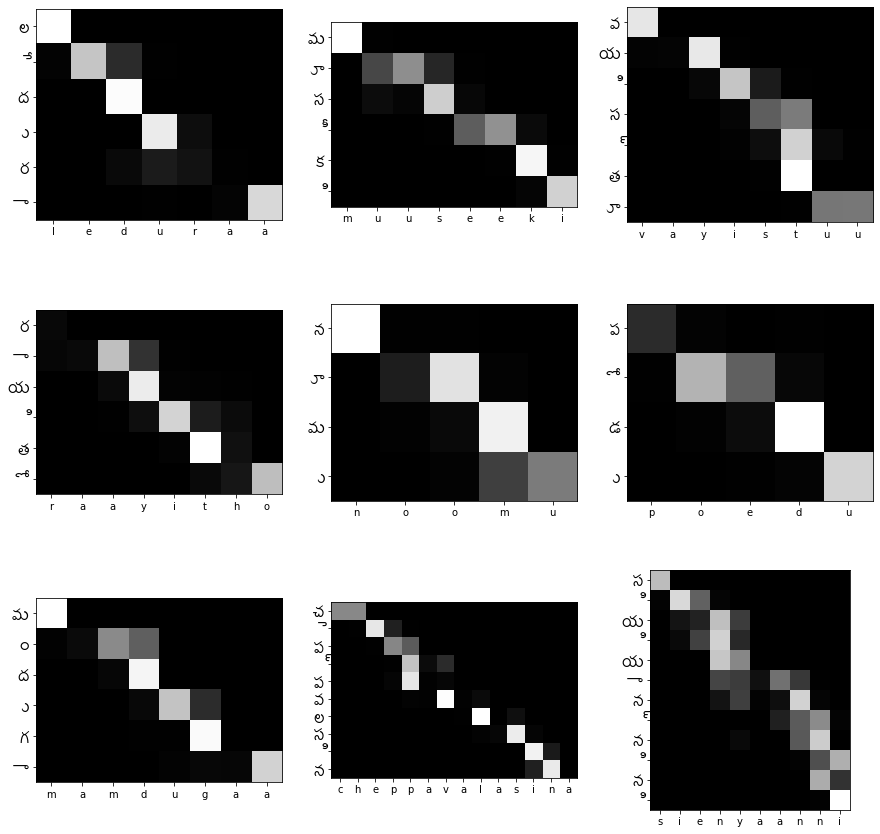

In [48]:
# coding: utf-8
from matplotlib.font_manager import FontProperties

random_indexes = []
# outputs = []
# inputs = []
for i in range(9):
    a = np.random.randint(0,len(test_outputs))
    random_indexes.append(a)
fig = plt.figure(figsize = (15,15))
x = 1
for i in range(9):
    accruracy , z, attention = beam_evaluate_single(test_input_tensor,test_outputs,random_indexes[i],1,enc_model,dec_model,'LSTM')
    # print(attention)
    attention = np.asarray(np.asarray(attention)[:,0,:])
    s = attention.shape
    attention = attention.reshape(s[0],s[2])[:,:s[0]]
    plt.subplot(3,3,x)
    # print(attention.shape,attention)
    for a, b in z:
        decoded_word = a[1:-1]
        expected_word = b 
    input_word = test_inputs[random_indexes[i]]
    print(len(input_word),input_word)
    print(len(decoded_word),decoded_word)
    attention = attention[:len(decoded_word),:len(input_word)]
    print(attention)
    plt.imshow(attention,cmap='gray')
    font_prop = FontProperties(fname='Lohit-Telugu.ttf', size=18)
   
    # plt.xlim(len(input_word))
    # plt.ylim(len(input_word))
    labels = []
    for s in decoded_word:
        labels.append(s)

    plt.yticks(range(len(labels)),labels,fontproperties = font_prop)
    plt.xticks(range(len(input_word)),input_word)
    x+=1
    
    



# Visualization

In [52]:
from textualheatmap import TextualHeatmap

In [136]:
import math
def data_string1(attention,output,input):
    ## attention shape len(output) x len(input)  
    data = []
    dic_list = []
    for i in range(len(output)):
        l = []
        a = []
        for j in range(len(input)):
            a.append((-math.log(attention[i][j]),input[j]))
        a.sort()
        m = []
        for j in range(4):
            if a[j][0] <= 3:
                m.append(a[j][1])
        d = dict()
        d["token"] =  output[i]
        d["meta"] = m
        d["heat"] = [1.0]
        d1 = dict()
        d1["token"] = ' '
        d1["format"] = False
        dic_list.append(d)
        dic_list.append(d1)
    data.append(dic_list)
    return data
    

"


In [83]:
print(output_index)

{'\t': 1, '\n': 2, 'ం': 3, 'ః': 4, 'అ': 5, 'ఆ': 6, 'ఇ': 7, 'ఈ': 8, 'ఉ': 9, 'ఊ': 10, 'ఋ': 11, 'ఎ': 12, 'ఏ': 13, 'ఐ': 14, 'ఒ': 15, 'ఓ': 16, 'ఔ': 17, 'క': 18, 'ఖ': 19, 'గ': 20, 'ఘ': 21, 'చ': 22, 'ఛ': 23, 'జ': 24, 'ఝ': 25, 'ఞ': 26, 'ట': 27, 'ఠ': 28, 'డ': 29, 'ఢ': 30, 'ణ': 31, 'త': 32, 'థ': 33, 'ద': 34, 'ధ': 35, 'న': 36, 'ప': 37, 'ఫ': 38, 'బ': 39, 'భ': 40, 'మ': 41, 'య': 42, 'ర': 43, 'ఱ': 44, 'ల': 45, 'ళ': 46, 'వ': 47, 'శ': 48, 'ష': 49, 'స': 50, 'హ': 51, 'ా': 52, 'ి': 53, 'ీ': 54, 'ు': 55, 'ూ': 56, 'ృ': 57, 'ె': 58, 'ే': 59, 'ై': 60, 'ొ': 61, 'ో': 62, 'ౌ': 63, '్': 64, '\u200c': 65}


In [92]:

def data_string2(attention,output,input):
    ## attention shape len(output) x len(input)  
    data = []
    dic_list = []
    i = 0
    while i < (len(output)):
        token = output[i]
        a = []
        for j in range(len(input)):
            a.append((-math.log(attention[i][j]),input[j]))
        a.sort()
        m = []
        
        mst = "Core: "
        for j in range(4):
            if a[j][0] <= 3:
                mst = mst + a[j][1] + " "
        m.append(mst)
        while(  ( (i+1)<len(output) ) and ( output_index[output[i+1]] < 5 or output_index[output[i+1]] > 51) ):
            i+=1
            token += output[i]
            a = []
            for j in range(len(input)):
                a.append((-math.log(attention[i][j]),input[j]))
            a.sort()
            mst = output[i] + ": "
            for j in range(4):
                if a[j][0] <= 3:
                    mst = mst + a[j][1] + " "
            m.append(mst)

        d = dict()
        d["token"] =  token
        d["meta"] = m
        d["heat"] = [1.0]
        d1 = dict()
        d1["token"] = ' '
        d1["format"] = True
        dic_list.append(d)
        i+=1
        dic_list.append(d1)
    data.append(dic_list)
    return data



In [93]:
# coding: utf-8
from matplotlib.font_manager import FontProperties

random_indexes = []
# outputs = []
# inputs = []
for i in range(9):
    a = np.random.randint(0,len(test_outputs))
    random_indexes.append(a)
fig = plt.figure(figsize = (15,15))
x = 1
for i in range(1):
    accruracy , z, attention = beam_evaluate_single(test_input_tensor,test_outputs,random_indexes[i],1,enc_model,dec_model,'LSTM')
    # print(attention)
    attention = np.asarray(np.asarray(attention)[:,0,:])
    s = attention.shape
    attention = attention.reshape(s[0],s[2])[:,:s[0]]
    # plt.subplot(3,3,x)
    # print(attention.shape,attention)
    for a, b in z:
        decoded_word = a[1:-1]
        expected_word = b 
    input_word = test_inputs[random_indexes[i]]
    print(len(input_word),input_word)
    print(len(decoded_word),decoded_word)
    attention = attention[:len(decoded_word),:len(input_word)]
    data = data_string2(attention,decoded_word,input_word)
    print(data)
    heatmap = TextualHeatmap(facet_titles = ['Vis'], show_meta=True)
    heatmap.set_data(data)
    heatmap.highlight(159)
    
    



C:\Users\HP\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "
7 karakhi
4 కరకీ
[[{'token': 'క', 'meta': ['Core: k '], 'heat': [1.0]}, {'token': ' ', 'format': True}, {'token': 'ర', 'meta': ['Core: r a k '], 'heat': [1.0]}, {'token': ' ', 'format': True}, {'token': 'కీ', 'meta': ['Core: k ', 'ీ: i '], 'heat': [1.0]}, {'token': ' ', 'format': True}]]


In [124]:

# get html element
def cstr(s, color='black'):
	if s == ' ':
		return "<text style=color:#000;padding-left:10px;background-color:{}> </text>".format(color, s)
	else:
		return "<text style=color:#000;background-color:{}>{} </text>".format(color, s)
	
# print html
def print_color(t):
	display(html_print(''.join([cstr(ti, color=ci) for ti,ci in t])))

# get appropriate color for value
def get_clr(value):
	colors = ['#85c2e1', '#89c4e2', '#95cae5', '#99cce6', '#a1d0e8'
		'#b2d9ec', '#baddee', '#c2e1f0', '#eff7fb', '#f9e8e8',
		'#f9e8e8', '#f9d4d4', '#f9bdbd', '#f8a8a8', '#f68f8f',
		'#f47676', '#f45f5f', '#f34343', '#f33b3b', '#f42e2e']
	value = int((value * 100) / 5)
	return colors[value]

# sigmoid function
def sigmoid(x):
	z = 1/(1 + np.exp(-x)) 
	return z

In [ ]:

def visualize(output_values, result_list, cell_no):
	print("\nCell Number:", cell_no, "\n")
	text_colours = []
	for i in range(len(output_values)):
		text = (result_list[i], get_clr(output_values[i][cell_no]))
		text_colours.append(text)
	print_color(text_colours)


# Wandb Sweep

In [94]:
import wandb
from wandb.keras import WandbCallback
wandb.login(key="866040d7d81f67025d43e7d50ecd83d54b6cf977", relogin=False)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\HP/.netrc


True

In [95]:
sweep_config = {
    'method': 'grid', #grid, random
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
         'beam_size' : {
            'values' : [1]
        },
        'input_embed_size': {
            'values' : [32]
        },
        'hidden_size' : {
            'values' : [64]
        },
        'cell_type' : {
            'values' : ['GRU','LSTM','RNN']
        },
        'dropout' : {
            'values' : [0]
        },
       
    }
}

In [97]:
sweep_id = wandb.sweep(sweep_config, entity="mooizz",project="Rec_dakhashina")

Create sweep with ID: fee428b2
Sweep URL: https://wandb.ai/mooizz/Rec_dakhashina/sweeps/fee428b2


In [98]:
def get_Model(input_embed_size , hidden_size, cell_type, dropout):
    charinput = tf.keras.Input(shape=(None,),dtype='float32',name="input")
    embedding = tf.keras.layers.Embedding(num_input_chars+1,input_embed_size, name="embedding")(charinput)
    
    if cell_type == 'LSTM':
        encoder = tf.keras.layers.LSTM(hidden_size, return_sequences=True, return_state=True )
        encoder_outputs, state_h, state_c = encoder(embedding)
        encoder_states = [state_h, state_c]
    if cell_type == 'RNN':
        encoder = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=True, return_state=True )
        encoder_outputs, rnn_state = encoder(embedding)
    if cell_type == 'GRU':
        encoder = tf.keras.layers.GRU(hidden_size, return_sequences=True, return_state=True )
        encoder_outputs, gru_state = encoder(embedding)
        
    
    decoder_inputs = tf.keras.Input(shape=(None,),name="decoder_input")
    decoder_embedding = tf.keras.layers.Embedding(num_output_chars + 1,64, name="decoder_embedding",mask_zero=True)(decoder_inputs)
    
    if cell_type == 'LSTM':
        decoder_lstm = tf.keras.layers.LSTM(hidden_size, return_sequences=True, return_state=True)
        decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
    if cell_type == 'RNN':
        decoder_rnn = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=True, return_state=True)
        decoder_outputs, _ = decoder_rnn(decoder_embedding, initial_state=rnn_state)
    if cell_type == 'GRU':
        decoder_gru = tf.keras.layers.GRU(hidden_size, return_sequences=True, return_state=True)
        decoder_outputs, _ = decoder_gru(decoder_embedding, initial_state=gru_state)
    
    print(encoder_outputs.shape)
    # Attention layer
    attn_layer = AttentionLayer(name='attention_layer')
    attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

    # Concat attention input and decoder GRU output
    decoder_concat_input = tf.keras.layers.Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

    # Dense layer
    decoder_dense = tf.keras.layers.Dense(num_output_chars + 1, activation="softmax")
    dense_time = tf.keras.layers.TimeDistributed(decoder_dense, name='time_distributed_layer')
#     decoder_pred = dense_time(decoder_concat_input)
    
    decoder_outputs = dense_time(decoder_concat_input)
    
    model = tf.keras.Model([charinput,decoder_inputs],decoder_outputs)
    
    
    if cell_type == 'LSTM':
        encoder_states_attn = [encoder_outputs,state_h,state_c]
        encoder_model = tf.keras.Model(charinput, encoder_states_attn)
        # define inference decoder
    #     decoder_inf_out, decoder_inf_state = decoder_gru(decoder_inf_inputs, initial_state=decoder_init_state)
    #     attn_inf_out, attn_inf_states = attn_layer([encoder_inf_states, decoder_inf_out])
    #     decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_inf_out, attn_inf_out])
    #     decoder_inf_pred = TimeDistributed(dense)(decoder_inf_concat)
    #     decoder_model = Model(inputs=[encoder_inf_states, decoder_init_state, decoder_inf_inputs],
    #                           outputs=[decoder_inf_pred, attn_inf_states, decoder_inf_state])

        decoder_state_input_h = tf.keras.Input(shape=(hidden_size,))
        decoder_state_input_c = tf.keras.Input(shape=(hidden_size,))
        decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

        encoder_inf_states = tf.keras.Input(shape=(None,hidden_size), name='encoder_inf_states')
        decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding, initial_state=decoder_states_inputs)
        attn_inf_out, attn_inf_states = attn_layer([encoder_inf_states, decoder_outputs])
        decoder_inf_concat = tf.keras.layers.Concatenate(axis=-1, name='concat')([decoder_outputs, attn_inf_out])
        decoder_outputs = tf.keras.layers.TimeDistributed(decoder_dense)(decoder_inf_concat)
        decoder_states = [state_h, state_c]

        decoder_model = tf.keras.Model([decoder_inputs] + [encoder_inf_states,decoder_state_input_h,decoder_state_input_c]
                                       , [decoder_outputs] + decoder_states + [attn_inf_states])
    if cell_type == 'GRU':
        encoder_states_attn = [encoder_outputs,gru_state]
        
        encoder_model = tf.keras.Model(charinput, encoder_states_attn)
        decoder_state_input_h = tf.keras.Input(shape=(hidden_size,))
#         decoder_state_input_c = tf.keras.Input(shape=(hidden_size,))
#         decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

        encoder_inf_states = tf.keras.Input(shape=(None,hidden_size), name='encoder_inf_states')
        
        decoder_outputs, state_h = decoder_gru(decoder_embedding, initial_state=decoder_state_input_h)
        attn_inf_out, attn_inf_states = attn_layer([encoder_inf_states, decoder_outputs])
        decoder_inf_concat = tf.keras.layers.Concatenate(axis=-1, name='concat')([decoder_outputs, attn_inf_out])
        decoder_outputs = tf.keras.layers.TimeDistributed(decoder_dense)(decoder_inf_concat)
#         decoder_states = [state_h, state_c]

        decoder_model = tf.keras.Model([decoder_inputs] + [encoder_inf_states,decoder_state_input_h]
                                       , [decoder_outputs] + [state_h] + [attn_inf_states])
    if cell_type == 'RNN':
        encoder_states_attn = [encoder_outputs,rnn_state]
        
        encoder_model = tf.keras.Model(charinput, encoder_states_attn)
        decoder_state_input_h = tf.keras.Input(shape=(hidden_size,))
#         decoder_state_input_c = tf.keras.Input(shape=(hidden_size,))
#         decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

        encoder_inf_states = tf.keras.Input(shape=(None,hidden_size), name='encoder_inf_states')
        
        decoder_outputs, state_h = decoder_rnn(decoder_embedding, initial_state=decoder_state_input_h)
        attn_inf_out, attn_inf_states = attn_layer([encoder_inf_states, decoder_outputs])
        decoder_inf_concat = tf.keras.layers.Concatenate(axis=-1, name='concat')([decoder_outputs, attn_inf_out])
        decoder_outputs = tf.keras.layers.TimeDistributed(decoder_dense)(decoder_inf_concat)
#         decoder_states = [state_h, state_c]

        decoder_model = tf.keras.Model([decoder_inputs] + [encoder_inf_states,decoder_state_input_h]
                                       , [decoder_outputs] + [state_h] + [attn_inf_states])
        
    return model, encoder_model, decoder_model

In [99]:
def train():
    config_defaults = {
        'epochs' : 1,
        'batch_size' : 64,
        'optimizer' : 'adam',
        'beam_size' : 1,
        'input_embed_size': 32,
        'hidden_size' : 256,
        'cell_type' : 'LSTM',
        'dropout' : 0,
    }
    wandb.init(config=config_defaults)
    config = wandb.config
    model, enc_model, dec_model = get_Model(config.input_embed_size,config.hidden_size,
                     config.cell_type,
                     config.dropout)
    model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )
#     sample_model.summary()
    EarlyStopCB = tf.keras.callbacks.EarlyStopping(patience=30, monitor='val_accuracy',
                                                  restore_best_weights=True)
    tf.config.run_functions_eagerly(True)
#     model.fit(
#         [input_tensor,decoder_input_data],
#         decoder_output_data,
#         batch_size=config.batch_size,
#         epochs=config.epochs,
#         validation_data=(
#             [val_input_tensor,decoder_val_input_data],
#             decoder_val_output_data
#         ),
#         shuffle=True,
#         callbacks=[WandbCallback(), EarlyStopCB])
#     beam_acc , _ = beam_evaluate(test_input_tensor,test_outputs,10,config.beam_size,
#                                 enc_model,
#                                 dec_model,
#                                 config.cell_type)
    print("Testing")
#     wandb.log({'Test_Acc' : beam_acc})
    model.save('models'+os.sep+str(sweep_id)+os.sep+wandb.run.name)

In [100]:
wandb.agent(sweep_id, train)

500 response executing GraphQL.
{"errors":[{"message":"Invalid hyperparameter service response","path":["agentHeartbeat"]}],"data":{"agentHeartbeat":null}}
wandb: ERROR Error while calling W&B API: Invalid hyperparameter service response (<Response [500]>)
wandb: Agent Starting Run: tmb435kr with config:
wandb: 	beam_size: 1
wandb: 	cell_type: GRU
wandb: 	dropout: 0
wandb: 	hidden_size: 64
wandb: 	input_embed_size: 32
wandb: wandb version 0.10.30 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


(None, None, 64)
Testing


wandb: ERROR Error while calling W&B API: Invalid hyperparameter service response (<Response [500]>)
wandb: ERROR Error while calling W&B API: Invalid hyperparameter service response (<Response [500]>)
wandb: ERROR Error while calling W&B API: Invalid hyperparameter service response (<Response [500]>)


INFO:tensorflow:Assets written to: models\fee428b2\swept-sweep-1\assets


INFO:tensorflow:Assets written to: models\fee428b2\swept-sweep-1\assets


wandb: Ctrl + C detected. Stopping sweep.
